# Import Necessary Libraries

In [1]:
import os
import requests
import json
from urllib.parse import urljoin
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Download .json files corresponding to wildfires

In [2]:
# Capella imagery S3
base_url = "https://capella-open-data.s3.amazonaws.com/stac/capella-open-data-by-industry/capella-open-data-disaster-response/"
collection_url = urljoin(base_url, "collection.json")

# Save location 
local_directory = os.path.expanduser('~/FIREMAPS/Data/Wildfires')
os.makedirs(local_directory, exist_ok=True)


response = requests.get(collection_url)
collection = response.json()

for item in collection.get('links', []):
    item_href = item.get('href', '')

    # Filtering Capella images to be in January 2025 and in GEO format
    if item.get('rel') == 'item' and '202501' in item_href and 'GEO' in item_href:
        item_url = urljoin(base_url, item_href) 
        item_filename = os.path.basename(item_url)
        local_path = os.path.join(local_directory, item_filename)

        # Prevent "double download"
        if os.path.exists(local_path):
            print(f"Already downloaded file: {item_filename}")
            continue 

        try:
            item_response = requests.get(item_url)
            item_response.raise_for_status() 

            with open(local_path, 'w') as f:
                f.write(item_response.text)
            
            print(f"Downloaded: {item_filename}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {item_filename}: {e}")

print("Download process completed.")


Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655.json
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.json
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.json
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.json
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.json
Already downloaded file: CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.json
Already downloaded file: CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.json
Already downloaded file: CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.json
Already downloaded file: CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319.json
Already downloaded file: CAPELLA_C14_SS_GEO_HH_20250112081445_20250112081501.json
Already downloaded file: CAPELLA_C09_SP_GEO_HH_20250112071930_20250112071936.json
Already downloaded file: CAPELLA_C15_SS_GEO_HH_20250112055128_20250112055142.json
Already download

### Check list of .json files

In [3]:
json_files = [f for f in os.listdir(local_directory) if f.endswith('.json')]

if json_files:
    print("Downloaded JSON files:")
    for file in json_files:
        print(file)
else:
    print("No JSON files found in the directory.")


Downloaded JSON files:
CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.json
CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.json
CAPELLA_C09_SP_GEO_HH_20250112071930_20250112071936.json
CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.json
CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.json
CAPELLA_C15_SS_GEO_HH_20250111190504_20250111190518.json
CAPELLA_C14_SS_GEO_HH_20250111163649_20250111163705.json
CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319.json
CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.json
CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.json
CAPELLA_C15_SS_GEO_HH_20250112055128_20250112055142.json
CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.json
CAPELLA_C14_SS_GEO_HH_20250111145546_20250111145602.json
CAPELLA_C14_SS_GEO_HH_20250112081445_20250112081501.json
CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655.json


# Download .tif files corresponding to the .json files

In [4]:
s3_base_url = "https://capella-open-data.s3.amazonaws.com/data/"

for json_file in os.listdir(local_directory):
    if json_file.endswith('.json'):
        json_path = os.path.join(local_directory, json_file)

        # Get JSON metadata
        with open(json_path, 'r') as file:
            metadata = json.load(file)

        # Scene ID and Acquistion Date
        scene_id = json_file.replace('.json', '')
        acquisition_date = metadata["properties"]["start_datetime"]
        acquisition_date = acquisition_date.split('.')[0] + 'Z' 
        date_parts = acquisition_date.split('T')[0].split('-') 
        year, month, day = date_parts

        # Make .tif file URL
        tif_filename = f"{scene_id}.tif"
        tif_url = urljoin(s3_base_url, f"{year}/{int(month)}/{int(day)}/{scene_id}/{tif_filename}")
        local_tif_path = os.path.join(local_directory, tif_filename)

        # Prevent "double download"
        if os.path.exists(local_tif_path):
            print(f"Already downloaded file: {tif_filename}")
            continue  

        try:
            print(f"Downloading {tif_filename}...")
            tif_response = requests.get(tif_url, stream=True)
            tif_response.raise_for_status()  

            with open(local_tif_path, 'wb') as f:
                for chunk in tif_response.iter_content(chunk_size=8192):
                    f.write(chunk)

            print(f"Downloaded: {tif_filename}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {tif_filename}: {e}")

print("Download process completed.")


Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.tif
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.tif
Already downloaded file: CAPELLA_C09_SP_GEO_HH_20250112071930_20250112071936.tif
Already downloaded file: CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.tif
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.tif
Already downloaded file: CAPELLA_C15_SS_GEO_HH_20250111190504_20250111190518.tif
Already downloaded file: CAPELLA_C14_SS_GEO_HH_20250111163649_20250111163705.tif
Already downloaded file: CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319.tif
Already downloaded file: CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.tif
Already downloaded file: CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.tif
Already downloaded file: CAPELLA_C15_SS_GEO_HH_20250112055128_20250112055142.tif
Already downloaded file: CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif
Already downloaded file: CAP

# Visualize a .tif file

(6223, 7855)


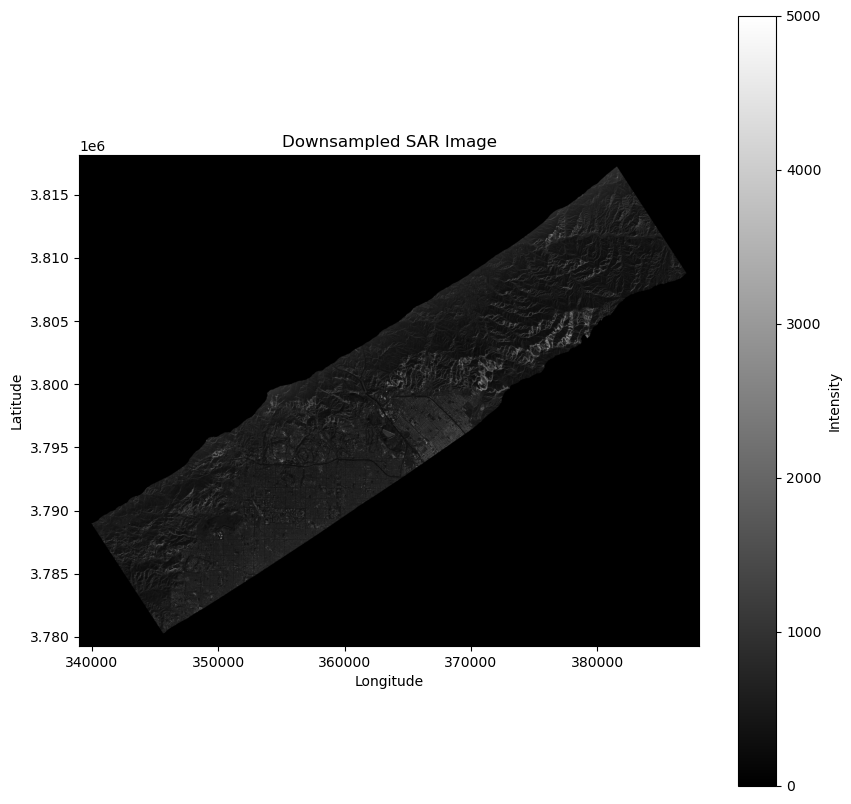

In [6]:
tif_file = os.path.expanduser('~/FIREMAPS/Data/Wildfires/CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif')  # Replace with your filename

with rasterio.open(tif_file) as src:
    down_factor = 6  
    new_height = src.height // down_factor
    new_width = src.width // down_factor

    img_data = src.read(
        1,  
        out_shape=(new_height, new_width), 
        resampling=Resampling.average 
    )
    print(np.shape(img_data))

    plt.figure(figsize=(10, 10))
    plt.imshow(img_data, cmap='gray', extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top),
               vmin = 000, vmax = 5000)
    plt.title("Downsampled SAR Image")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Intensity")
    plt.show()


### Create an interactive plot if desired

In [1]:
#import plotly.express as px
#from rasterio.enums import Resampling
#
## Define the path to the .tif file
#tif_file = os.path.expanduser('~/FIREMAPS/Data/Wildfires/CAPELLA_C02_SM_GEO_HH_20201207083444_20201207083448.tif')  # Replace with your filename
#
## Open the .tif file using rasterio
#with rasterio.open(tif_file) as src:
#    # Define downsampling factor (adjust as needed)
#    scale_factor = 4  
#
#    # Compute new shape
#    new_height = src.height // scale_factor
#    new_width = src.width // scale_factor
#
#    # Read and resample the first band
#    img_data = src.read(
#        1,  # Read the first band
#        out_shape=(new_height, new_width),  # Downsampled size
#        resampling=Resampling.average  # Smooths out noise
#    )
#
#    # Get spatial extent (georeferencing)
#    left, bottom, right, top = src.bounds
#    x = np.linspace(left, right, new_width)
#    y = np.linspace(bottom, top, new_height)
#
## Create an interactive plot with Plotly
#fig = px.imshow(
#    img_data,
#    color_continuous_scale="gray",  # SAR images are usually grayscale
#    labels={'x': "Longitude", 'y': "Latitude", 'color': "Intensity"}
#)
#
#fig.update_layout(
#    title="Interactive SAR Image Viewer",
#    xaxis_title="Longitude",
#    yaxis_title="Latitude",
#    dragmode="pan"
#)

# Show interactive plot
#fig.show()
